#**TRABAJO FINAL**

#Resumen

El objetivo de este trabajo es poder caracterizar distintas señales para la deteccion del estrés y para poder distinguir 3 etapas de respiración diferente ( normal, rápida y lenta). Para conseguir esto se analizan las señales de 9 pacientes.
Una vez caracterizada cada señal y cada etapa, se construye una matriz de características. Se analizó cuáles caracteristicas eran relevantes. Por ultimo, se presenta esta información a un algoritmo de Machine Learning para realizar la clasificación y detectar las diferentes etapas para luego proceder a la validación del modelo.



---





#Introducción

El estrés es la respuesta del cuerpo a una presión física, mental o emocional y se manifiesta principalmente sobre el sistema nervioso. El estrés produce cambios químicos que elevan la presión arterial, la frecuencia cardíaca y las concentraciones de azúcar en la sangre. También suele producir sentimientos de frustración, ansiedad, enojo o depresión.

Varios estudios adoptan una técnica de aprendizaje automático supervisado para la clasificacón del evento de estrés. Los principales parámetros fisiológicos de análisis son frecuencia cardíaca, frecuencia respiratoria, presión sanguinea, temperatura de la piel, respuesta galvánica de la piel y hasta electrooculograma. 

Este tipo de analisis permite detectar episodios de estrés o incluso el diagnóstico del mismo de manera objetiva.

Por ejemplo, la señal de impedancia galvanica de la piel refleja la activación del SNA, encargado del control de funciones viscerales tales como la frecuencia cardiaca, la digestión, la respiración o la transpiración. Por esta razón,  en el estudio del estrés de un organismo esta señal suele considerarse por su relación con diversos factores que regulan la respuesta frente al estrés. 

En particular, en este caso las señales de análisis fueron la presión de pulso (BVP), impedancia galvánica de la piel (GSR)  y frecuencia cardiaca (HR). A lo largo del trabajo, trataremos de caracterizar las mismas para poder identificar las diferentes etapas del experimento con 9 pacientes.


---

#Montado de Drive - Librerias

Montamos el drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Librerias a utilizar

In [ ]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import scipy.io
import scipy.interpolate
from scipy.fft import fft
import math as m
import pandas as pd
from scipy.linalg import toeplitz

#Información de la señal

Los datos consisten en la estructura Pt que contienen tres señales BVP, GSR y HR:
*  Pt. control: para la fase de control, al principio del
experimento
*  Pt.RN: para la fase de respiración normal ojos cerrados
* Pt.RR: para la fase de respiración rapida ojos cerrados
* Pt.RL: para la fase de respiración lenta ojos cerrados
* Analogamente Pt.TN, Pt.TR y Pt.TL tienen las tres señales para los tests cognitivos siguientes a las fases de resp normal (TN), rápida (TR) lenta (TL). 

#Desarrollo 

#Cargado de señales

In [ ]:
data1 = scipy.io.loadmat('/content/drive/MyDrive/TP Final PSB/E4 Stress/Pt_1583430177_A019F0.mat')
data2 = scipy.io.loadmat('/content/drive/MyDrive/TP Final PSB/E4 Stress/Pt_1583434861_A019F0.mat')
data3 = scipy.io.loadmat('/content/drive/MyDrive/TP Final PSB/E4 Stress/Pt_1583498387_A019F0.mat')
data4 = scipy.io.loadmat('/content/drive/MyDrive/TP Final PSB/E4 Stress/Pt_1583755675_A019F0.mat')
data5 = scipy.io.loadmat('/content/drive/MyDrive/TP Final PSB/E4 Stress/Pt_1583771510_A019F0.mat')
data6 = scipy.io.loadmat('/content/drive/MyDrive/TP Final PSB/E4 Stress/Pt_1583841918_A019F0.mat')
data7 = scipy.io.loadmat('/content/drive/MyDrive/TP Final PSB/E4 Stress/Pt_1583928278_A019F0.mat')
data8 = scipy.io.loadmat('/content/drive/MyDrive/TP Final PSB/E4 Stress/Pt_1583948360_A019F0.mat')
data9 = scipy.io.loadmat('/content/drive/MyDrive/TP Final PSB/E4 Stress/Pt_1583949749_A019F0.mat')


Definimos una función para cargar las señales de cada paciente con mayor facilidad. La función devuelve un diccionario con las señales GSR, BVP y HR de cada etapa.

Nota: Las tres etapas del test cognitivo se reunieron en una unica señal . Ademas, los primeros dos elementos de cada señal fueron eliminados ya que correspondían al tiempo en que se comenzó a extraer la señal del paciente y a su frecuencia de muestreo

In [ ]:
def seniales(data):

  x=data['Pt'][0][0]
  marcas_tiempos=x[4]

  #senial BVP completa
  BVP=x[0]
  tiempo=BVP[0]
  fs_BVP=BVP[1]
  BVP=BVP[2:-1]

 #senial HR completa
  HR=x[1]
  tiempo=HR[0]
  fs_HR=HR[1]
  HR=HR[2:-1]

 #senial GSR completa
  GSR=x[2]
  tiempo=GSR[0]
  fs_GSR=GSR[1]
  GSR=GSR[2:-1]

 #senial temperatura completa
  TMP=x[5]
  tiempo=TMP[0]
  fs_TMP=TMP[1]
  TMP=TMP[2:-1]

  #no nos importan
  #cuatro1=x[3][:,0]
  #cuatro2=x[3][:,1]
  #cuatro3=x[3][:,2]

 #segmentos con las diferentes fases
  Control_BVP=x[6][0][0][0]   #bvp
  Control_GSR=x[6][0][0][1]   #gsr
  Control_HR=x[6][0][0][2]   #hr

  RN_BVP=x[7][0][0][0]
  RN_GSR=x[7][0][0][1]
  RN_HR=x[7][0][0][2]

  RR_BVP=x[8][0][0][0]
  RR_GSR=x[8][0][0][1]
  RR_HR=x[8][0][0][2]

  RL_BVP=x[9][0][0][0]
  RL_GSR=x[9][0][0][1]
  RL_HR=x[9][0][0][2]

  TN_BVP=x[10][0][0][0]
  TN_GSR=x[10][0][0][1]
  TN_HR=x[10][0][0][2]

  TR_BVP=x[11][0][0][0]
  TR_GSR=x[11][0][0][1]
  TR_HR=x[11][0][0][2]

  TL_BVP=x[12][0][0][0]
  TL_GSR=x[12][0][0][1]
  TL_HR=x[12][0][0][2]
  
 #vamos a unir todas las fases de estres de cada senial
  TN_BVP=TN_BVP.tolist()
  TR_BVP=TR_BVP.tolist()
  TL_BVP=TL_BVP.tolist()
  test_BVP=TN_BVP+TR_BVP+TL_BVP

  TN_GSR=TN_GSR.tolist()
  TR_GSR=TR_GSR.tolist()
  TL_GSR=TL_GSR.tolist()
  test_GSR=TN_GSR+TR_GSR+TL_GSR

  TN_HR=TN_HR.tolist()
  TR_HR=TR_HR.tolist()
  TL_HR=TL_HR.tolist()
  test_HR=TN_HR+TR_HR+TL_HR

  #estres total de cada senial
  test_HR=np.array(test_HR)
  test_GSR=np.array(test_GSR)
  test_BVP=np.array(test_BVP)



  dic={ 'Marcas': marcas_tiempos,'Tiempo':tiempo,'GSR':[fs_GSR,GSR,Control_GSR, RN_GSR,RR_GSR,RL_GSR,TN_GSR,TR_GSR,TL_GSR], 'BVP':[fs_BVP,BVP,Control_BVP,RN_BVP,RR_BVP,RL_BVP,TN_BVP,TR_BVP,TL_BVP], 'HR':[fs_HR,HR,Control_HR,RN_HR,RR_HR,RL_HR,TN_HR,TR_HR,TL_HR], 'Test':[test_BVP, test_GSR, test_HR]}

  return dic

De esta forma, cargamos las señales para cada paciente

In [ ]:
P1=seniales(data1)
P2=seniales(data2)
P3=seniales(data3)
P4=seniales(data4)
P5=seniales(data5)
P6=seniales(data6)
P7=seniales(data7)
P8=seniales(data8)
P9=seniales(data9)

Graficamos las funciones enteras para uno de los pacientes

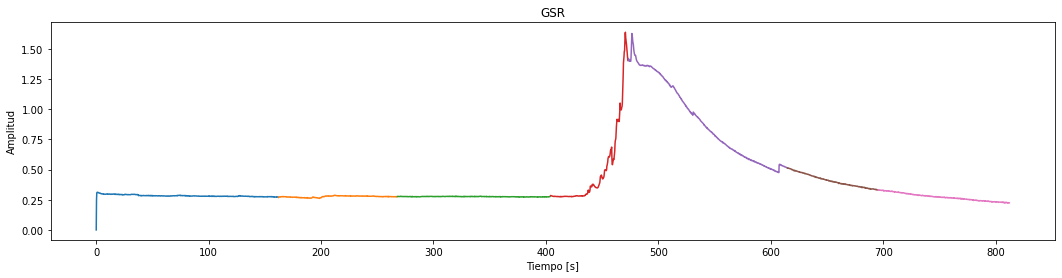

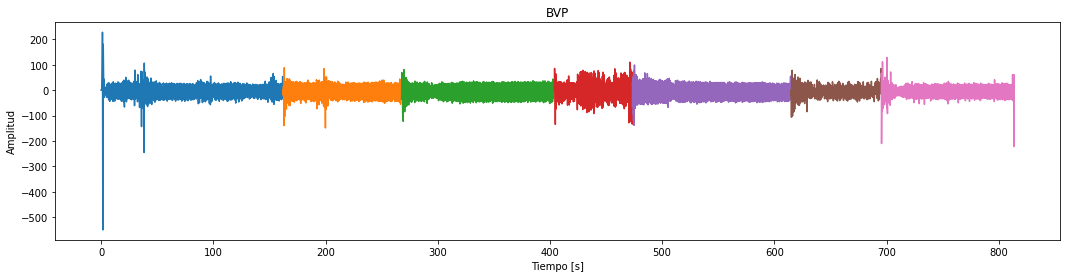

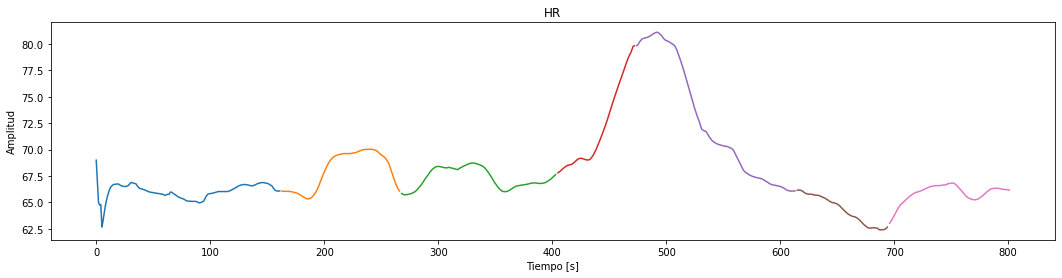

In [ ]:
P=P1

fs_GSR=P['GSR'][0][0]
GSR=P['GSR'][1]
marcass=P['Marcas'][:,0]
tiem=P['Tiempo']


marcasG=np.zeros(len(marcass))
for i in range(0,len(marcass)):
  marcasG[i]=(marcass[i]-tiem)*fs_GSR
marcasG=marcasG.astype(int)

t_GSR = np.arange(0,len(GSR)/fs_GSR,1/fs_GSR) 

plt.figure(figsize=(18,4))
inicio=0
for i in marcasG:
  plt.plot(t_GSR[inicio:i],GSR[inicio:i])
  inicio=i+1
plt.plot(t_GSR[inicio:-1],GSR[inicio:-1])
plt.title('GSR')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.show()


fs_BVP=P['BVP'][0][0]
BVP=P['BVP'][1][:,0]
t_BVP = np.arange(0,len(BVP)/fs_BVP,1/fs_BVP) 

marcasB=np.zeros(len(marcass))
for i in range(0,len(marcass)):
  marcasB[i]=(marcass[i]-tiem)*fs_BVP
marcasB=marcasB.astype(int)

plt.figure(figsize=(18,4))
inicio=0
for i in marcasB:
  plt.plot(t_BVP[inicio:i],BVP[inicio:i])
  inicio=i+1
plt.plot(t_BVP[inicio:-1],BVP[inicio:-1])
plt.title('BVP')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.show()

fs_HR=P['HR'][0][0]
HR=P['HR'][1][:,0]

marcasH=np.zeros(len(marcass))
for i in range(0,len(marcass)):
  marcasH[i]=(marcass[i]-tiem)*fs_HR
marcasH=marcasH.astype(int)

t_HR = np.arange(0,len(HR)/fs_HR,1/fs_HR) 

plt.figure(figsize=(18,4))
inicio=0
for i in marcasH:
  plt.plot(t_HR[inicio:i],HR[inicio:i])
  inicio=i+1
plt.plot(t_HR[inicio:-1],HR[inicio:-1])
plt.title('HR')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.show()

#Gráficos de funciones para cada paciente

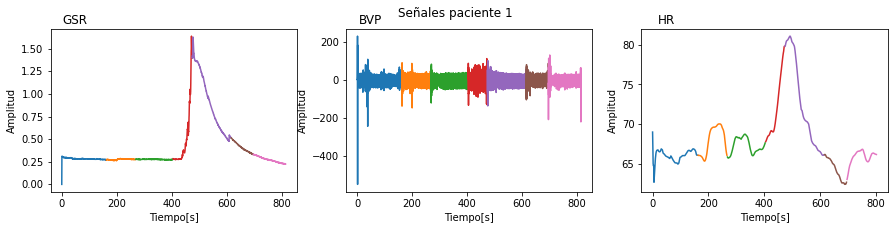

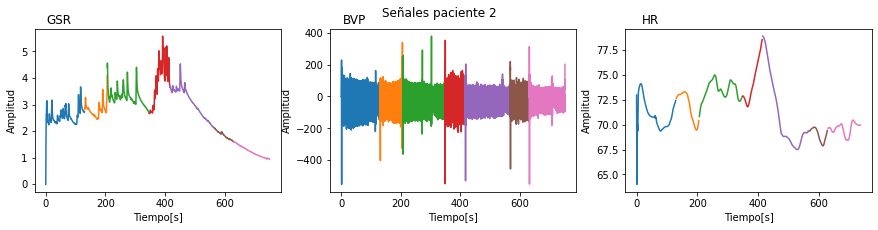

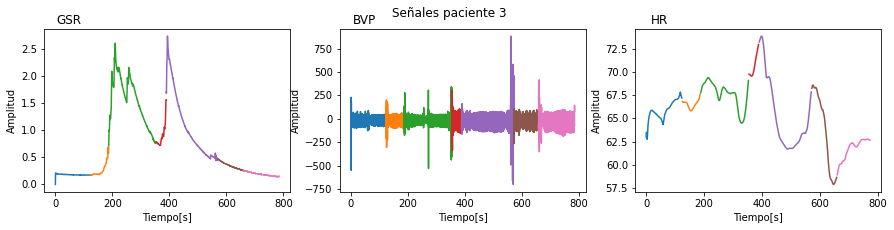

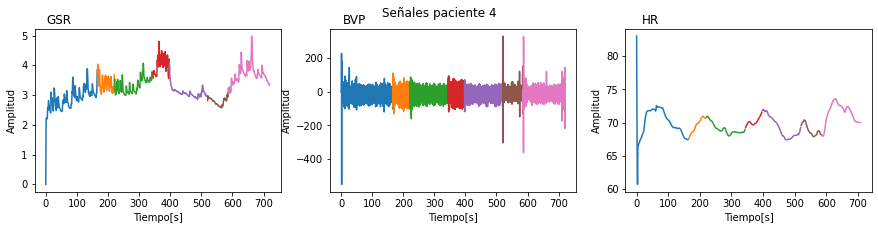

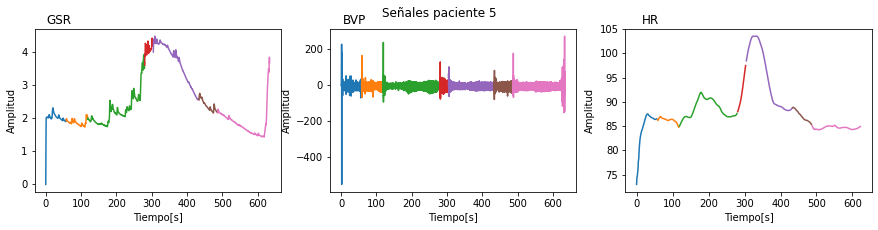

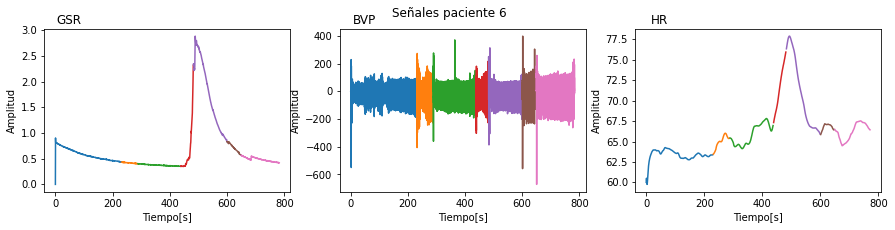

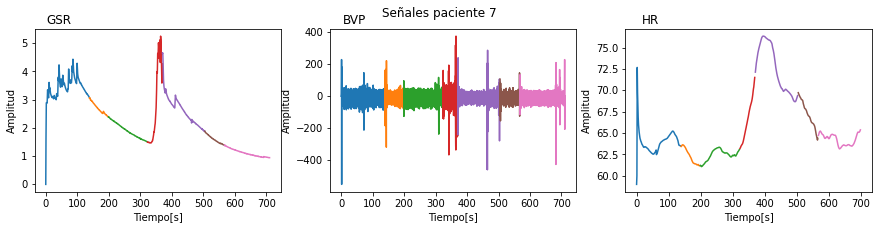

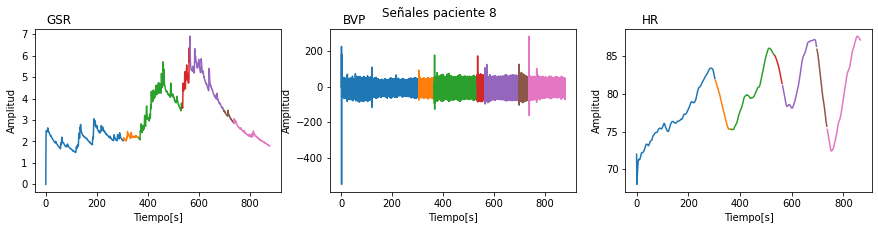

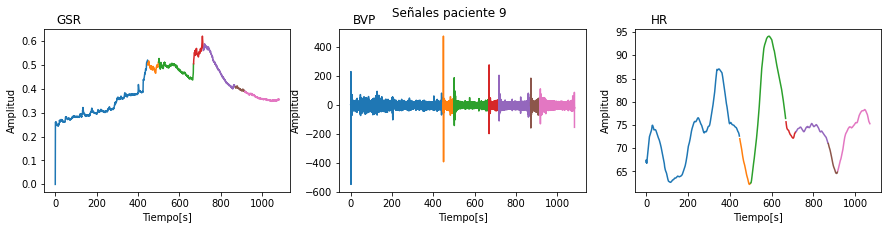

In [ ]:
pacientes=[P1, P2, P3, P4, P5, P6, P7, P8, P9]
for i in range(0,len(pacientes)):  
  fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,3))
  fig.suptitle('Señales paciente '+str(i+1))

  P=pacientes[i]
  fs_GSR=P['GSR'][0][0]
  GSR=P['GSR'][1]
  marcass=P['Marcas'][:,0]
  tiem=P['Tiempo']
  marcasG=np.zeros(len(marcass))
  for i in range(0,len(marcass)):
    marcasG[i]=(marcass[i]-tiem)*fs_GSR
  marcasG=marcasG.astype(int)
  t_GSR = np.arange(0,len(GSR)/fs_GSR,1/fs_GSR) 
  
  inicio=0
  for i in marcasG:
    ax1.plot(t_GSR[inicio:i],GSR[inicio:i])
    inicio=i+1
  ax1.plot(t_GSR[inicio:-1],GSR[inicio:-1])

  fs_BVP=P['BVP'][0][0]
  BVP=P['BVP'][1][:,0]
  t_BVP = np.arange(0,len(BVP)/fs_BVP,1/fs_BVP) 

  marcasB=np.zeros(len(marcass))
  for i in range(0,len(marcass)):
    marcasB[i]=(marcass[i]-tiem)*fs_BVP
  marcasB=marcasB.astype(int)
  inicio=0
  for i in marcasB:
    ax2.plot(t_BVP[inicio:i],BVP[inicio:i])
    inicio=i+1
  ax2.plot(t_BVP[inicio:-1],BVP[inicio:-1])

  fs_HR=P['HR'][0][0]
  HR=P['HR'][1][:,0]
  t_HR = np.arange(0,len(HR)/fs_HR,1/fs_HR) 

  marcasH=np.zeros(len(marcass))
  for i in range(0,len(marcass)):
    marcasH[i]=(marcass[i]-tiem)*fs_HR
  marcasH=marcasH.astype(int)
  inicio=0
  for i in marcasH:
    ax3.plot(t_HR[inicio:i],HR[inicio:i])
    inicio=i+1
  ax3.plot(t_HR[inicio:-1],HR[inicio:-1])
  ax3.set_xlabel('Tiempo[s]')
  ax3.set_ylabel('Amplitud')
  ax2.set_xlabel('Tiempo[s]')
  ax2.set_ylabel('Amplitud')
  ax1.set_xlabel('Tiempo[s]')
  ax1.set_ylabel('Amplitud')
  ax1.set_title('GSR')

  ax2.set_title('BVP')
  ax3.set_title('HR')
  ax1.title.set_position([0.1, 0.99])
  ax2.title.set_position([0.1, 0.99])
  ax3.title.set_position([0.1, 0.99])


# Definición de Funciones para evaluar Características







El objetivo del trabajo es poder definir en qué etapa se encuentra el paciente (ya sea que esta experimentando una respiracion rápida, lenta, normal o si se encuentra bajo una situación de estrés).

Para eso, se definiran características de cada señal para evaluar si con ellas es posible caracterizar cada etapa teniendo en cuenta los pedidos de la consigna y además otras consideradas en algunas investigaciones (ver sección "Referencias")


## Características que vamos a evaluar de la señal de GSR



La conductancia de la piel es una indicación de excitación psicológica o fisiológica, por ejemplo, el grado de intensidad de la excitación o miedo.

Esta conductividad de la piel está regulada por el sistema nervioso autónomo, que controla una serie de procesos corporales que pueden influir en los comportamientos cognitivos y emocionales.

 Entre otras respuestas, la rama simpática del sistema nervioso autónomo hace sudar, lo que aumenta la conductancia de la piel. Por lo tanto, la señal de GSR va a variar según la sudoración de la zona. Como las glándulas sudoriparas son controladas por el sistema simpático, al medir la señal de GSR se obtiene información de la activación simpática.  


Si bien la consigna pide evaluar la media y la desvio por tramos, decidimos tambien evaluar las siguientes caracteristicas:
* Cantidad de picos
* La suma de la amplitud de los picos 
* La media de la derivada de la señal 


La cantidad de picos en cada fase es indicativo de la influencia del sistema simpático en dicha fase: Un número mayor de picos indicaría mayor actividad simpática que como dijimos, puede estar relacionada a un episodio de estrés. 

Análogamente , evaluando la derivada de la señal, podemos inferir que una derivada más positiva indicaría aumento en la actividad simpática y podría también de esta forma indicar un episiodio de estrés.

In [ ]:
def derivar(senal,fs): #Filtro derivativo
  Ts=1/fs
  fs=int(fs)
  b=[fs,-fs]
  return scipy.signal.filtfilt(b, 1 ,senal) 

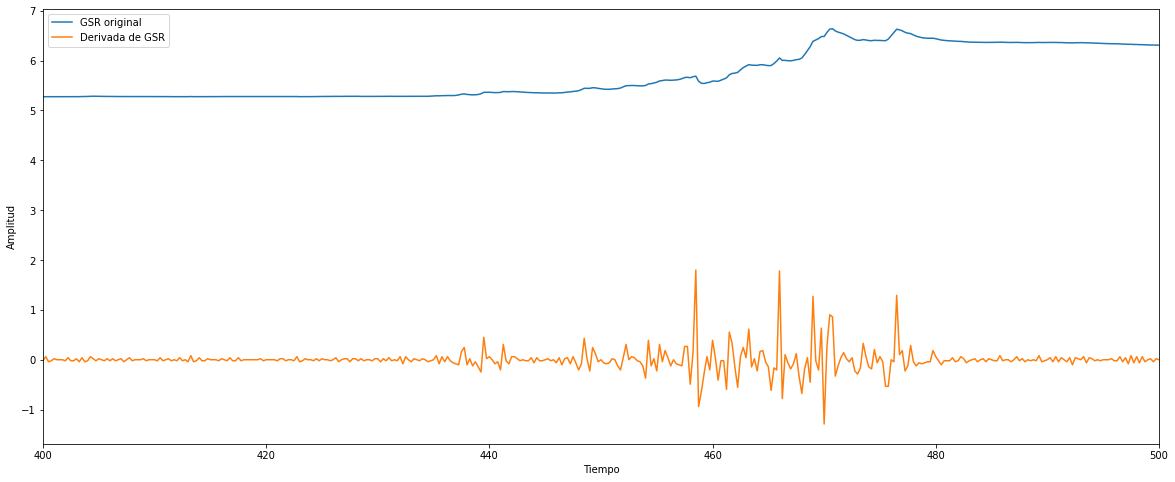

In [ ]:

fs=P1['GSR'][0]
fs=fs[0]
x=P1['GSR'][1][:,0]
t = np.arange(0,len(x)/fs,1/fs) 
derivada=derivar(x,fs)


plt.figure(figsize=(20,8))
plt.plot()
plt.plot(t,x+5,label="GSR original")
plt.plot(t,derivar(x+2,fs),label="Derivada de GSR")
plt.xlim([400,500])
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.legend()
plt.show()



In [ ]:
def picos(signal):
  picos=scipy.signal.find_peaks(signal)[0] #devuelve los indicies de los picos
  V=len(picos)/len(signal)
  return V

In [ ]:
def sum_amplitudes(x): #funcion que devuelve la suma de la amplitud de los picos
  picos=scipy.signal.find_peaks(x)[0]
  amplitud=0
  for i in picos:
    amplitud+=x[i]
  
  return amplitud/(len(picos))

##Características que vamos a evaluar de la señal de HR


La frecuencia cardíaca es el número de latidos por unidad de tiempo. Se basa en el número de contracciones de los ventrículos. Cuando el corazón late por encima de los 100 latidos por minuto, se considera que el sujeto se encuentra en taquicardia, y valores inferiores a 50 latidos por minuto, indican una situacion de bradicardia. 

Por lo tanto las caracteristicas que vamos a evaluar de la señal de HR son:

* Frecuencia dominante del espectro
* Amplitud máxima de la señal
* Mínimo de la señal
* Media 
* Varianza
* Desvío


##Características que vamos a evaluar de la señal de BVP
 


Con la señal de BVP es posible realizar el analisis de la variabilidad de la frecuencia cardíaca (HRV). La HRV es un indicador de la salud del corazón. 
Para realizar dicho análisis, debemos obtener los intervalos entre latidos
  Por lo tanto se detectan los distintos puntos donde se da la diástole y se restan los momentos de ocurrencia, obteniendo así la serie RR.

Luego, como sugiere la consigna, analizaremos la potencia en dos franjas de frecuencia a través del periodograma de Lomb. 
Los rangos de frecuencia analizados aportan información sobre el balance del sistema autónomo. La banda de baja frecuencia está relacionada a la actividad simpática y la de alta frecuencia a la actividad parasimpática. Por lo que un aumento en la potencia de la banda de alta frecuencia puede indicar un episodio de estrés y un aumento en la banda de baja frecuencia podria indicar la ausencia del mismo.

Por lo tanto, las caracteristicas que vamos a evaluar de la señal de BVP

* Potencia en la banda de baja frec (0-0.15hz) 
* Potencia en la banda de alta frec (0.15-0.40hz)
* Frecuencia dominante 
* Proporcion de intervalos RR que ocurren poco espaciados
* Desvio de la serie RR

In [ ]:
def calcular_Espectro(x,fs,xlim,plotting=False): 
  #Funcion que calcula la transformada y devuelve la frecuencia dominante 
  
  from scipy.fft import fft #hace la transformada rapida de fourier
  espectro = fft(x) #hacemos la transformada de foutier
  L = espectro.shape[0] #tamaño de la tf 
  densidad= abs(espectro**2)/L #densidad espectral de energia= tf al cuadrado y dividido por la cantidad
  densidad_mitad=densidad[0:int(L/2)]
  f = np.linspace(0,1,L) * fs #armamos vector de frecuencias
  frecuencias=scipy.signal.find_peaks(densidad_mitad)[0]
  
  if len(frecuencias)==0:
    f_=0
  else:
  
    frecuencia_max=(max(densidad_mitad[frecuencias]))
    lista=densidad_mitad.tolist()
    frecuencia=lista.index(frecuencia_max)
    f_=f[frecuencia]
  

    if plotting:

      plt.figure(figsize=(20,8))
      plt.plot(f[0:int(L/2)],densidad[0:int(L/2)], label='Señal limpia') #nos quedamos con la mitad porque es simetrica
      plt.xlim([0, xlim])
      plt.xlabel('Frecuencia')
      plt.ylabel('Amplitud')
  
  return f_

In [ ]:
! pip install wfdb # https://github.com/MIT-LCP/wfdb-python
# https://wfdb.readthedocs.io/en/latest/
import wfdb 
! pip install pyhrv # https://pypi.org/project/pyhrv/
import pyhrv

     |████████████████████████████████| 143kB 5.2MB/s 
     |████████████████████████████████| 3.2MB 4.9MB/s 
     |████████████████████████████████| 92kB 8.6MB/s 
     |████████████████████████████████| 235kB 39.5MB/s 
  Created wheel for biosppy: filename=biosppy-0.7.3-py2.py3-none-any.whl size=95429 sha256=fa89084923e17dbafca0cc65524266aee026c71c653074d94ed2527dc07003c1
  Stored in directory: /root/.cache/pip/wheels/20/83/40/b53b6db35cff70d0738e1fc4186f67c9e750184602aa3a5add
  Created wheel for spectrum: filename=spectrum-0.8.0-cp37-cp37m-linux_x86_64.whl size=234797 sha256=f053d5c44d153fd5ea88f0412784f512aeb2f3bc66633179c4b3ca8f1bba8a4a
  Stored in directory: /root/.cache/pip/wheels/62/de/fd/94dc5ad0a7d93803f4cb4a26744d21e91ac4bf0a63004d2b14
Successfully built biosppy spectrum


In [ ]:
def NN_BVP(x,fs,umbral,plotting=False):
  #Funcion para obtener la serie RR a partir de la señal de presion
  
  Ts=1/fs
  t = np.arange(0,len(x)/fs,1/fs) 


  candidatos=scipy.signal.find_peaks(-x) #devuelve los indicies de los picos
  candidatos=candidatos[0]
  minimo=-x[candidatos[0]]

  for i in range(1,len(candidatos)):
    if -x[candidatos[i]]<minimo:
      minimo=-x[candidatos[i]]

  #umbral= porcentaje de la amplitud maxima de la señal que se usa para el miimo
  u=umbral*minimo
  minimos=[]
  #detectamos minimos
  for i in range(len(candidatos)-1):
    if -x[candidatos[i]]>u and x[candidatos[i]]<-15: #la amplitud es mayor al umbral y ademas estamos en un minimo minimo
      #chequeamos si las muestras de los costados tambien son mayores al umbral
      if all(-x[j]>u and x[j]<0 for j in range(candidatos[i]-6, candidatos[i]+6,1)):
        if (abs(candidatos[i]-candidatos[i+1]))>15: #que la distancia entre minimos sea manor a 15
          minimos.append(candidatos[i])
    
  #Construir serie RR restando los tiempos consecutivos entre latidos
  if len(minimos)==0:
    RR=0
  else:
    RR = [j-i for i,j in zip(minimos[0:-2], minimos[1:-1])]
    if plotting:
      

      #Grafico RR
      plt.figure(figsize=(25,5))
      plt.stem(RR)
      plt.title('RR')
      plt.show()
      #Grafico señal BVP con los minimos que usamos para construir la serie RR
      plt.figure(figsize=(20,8))
      plt.plot(t,x,'y')
      plt.plot(t[minimos],x[minimos],'bo')
      plt.title('NN desde BVP')
      plt.ylabel('Amplitud')
      plt.xlabel('Tiempo [s]')
      plt.xlim(10,50)
      plt.show()

  return RR, minimos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


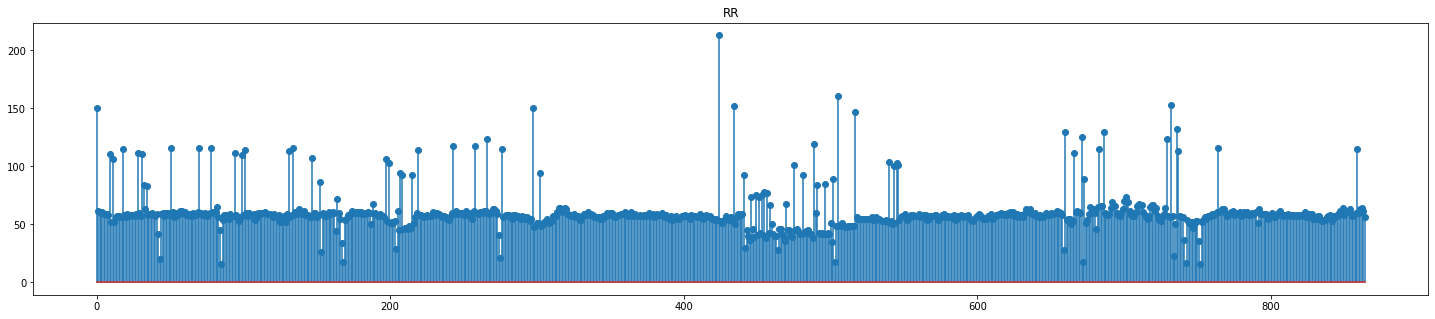

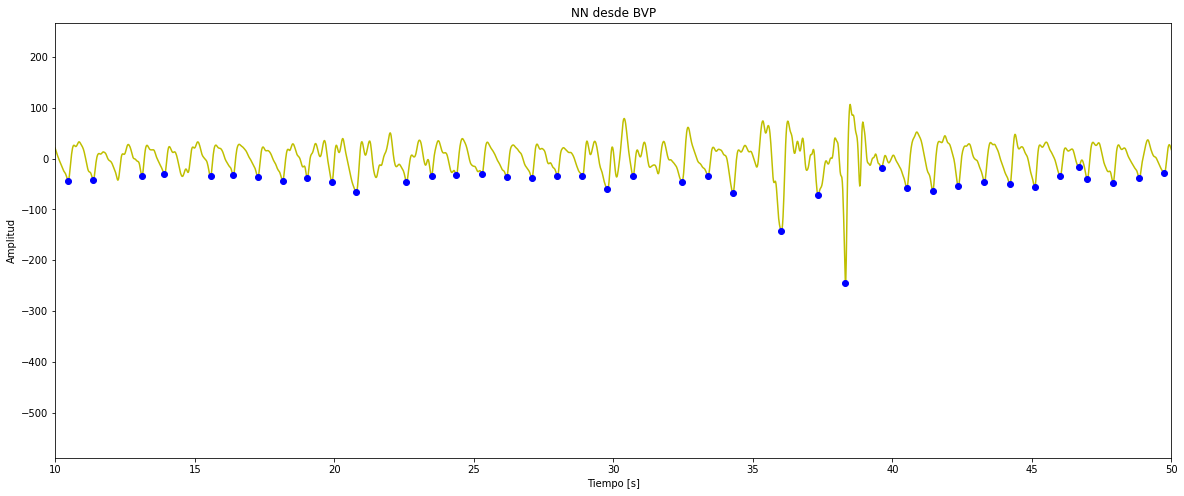

In [ ]:
fs=P1['BVP'][0][0]
señal=P1['BVP'][1][:,0]
señal=señal.astype(float)
serie,minimos=NN_BVP(señal,fs,0.99,plotting=True)


In [ ]:
def lomb(nni,minimoss):
  #Funcion que devuelve las potencias de interes a partir del periodograma de lomb
  import pyhrv
  import pyhrv.frequency_domain as fd
  
  if nni==0:
    alta=0
    baja=0
    fdom=0
  else:
    result = fd.lomb_psd(nni,minimoss)
    potencias = np.asarray(result['lomb_abs'])
    baja=potencias[0]+potencias[1]
    alta=potencias[2]
    result = fd.lomb_psd(nni)
    pico = np.asarray(result['lomb_peak'])
    fdom=np.max(pico)
  
  return alta,baja,fdom

In [ ]:
def RR_menores(serie,dist):
  #Funcion que calcula la proporcion de eventos en los que los latidos ocurren poco espaciados en el tiempo
  if serie==0:
    proporcion=0
  else:
    cantidad=0
    for i in range(len(serie)):
      if serie[i]<dist:
        cantidad+=1
    proporcion=cantidad/(len(serie))
  return proporcion

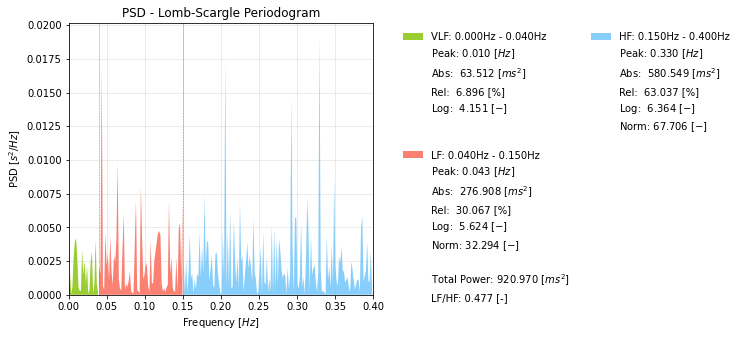

In [ ]:
fs=P1['BVP'][0][0]
x=P1['BVP'][1][:,0]
x=x.astype(float)

RR,minimos=NN_BVP(x,fs,0.98)
menores=RR_menores(RR,50) #proporcionsegmentos que son menroes a 50


from pyhrv import frequency_domain
tupla1 = frequency_domain.lomb_psd(nni=RR, rpeaks=minimos)

#Caracterizacion en cada paciente

###Funcion para determinar las caracteristicas GSR



*Que son entonces: Suma de la amplitud de los picos, Desvio, Media, Derivada, Cantidad de picos*

In [ ]:
def CARACTERISTICAS_GSR(Pi):
  fs=Pi['GSR'][0][0]

  #Analisis GSR RN
  RN=Pi['GSR'][3][:,0]
  RN=RN.astype(float)
  amp_RN=sum_amplitudes(RN)
  desvio_RN=np.std(RN)
  media_RN=np.mean(RN)
  derivada_RN=np.mean(derivar(RN,fs))
  picos_RN=picos(RN)

  #Analisis GSR RR
  RR=Pi['GSR'][4][:,0]
  RR=RR.astype(float)
  amp_RR=sum_amplitudes(RR)
  desvio_RR=np.std(RR)
  media_RR=np.mean(RR)
  derivada_RR=np.mean(derivar(RN,fs))
  picos_RR=picos(RR)

  #Analisis GSR RL
  RL=Pi['GSR'][5][:,0]
  RL=RL.astype(float)
  amp_RL=sum_amplitudes(RL)
  desvio_RL=np.std(RL)
  media_RL=np.mean(RL)
  derivada_RL=np.mean(derivar(RL,fs))
  picos_RL=picos(RL)

  #Analisis GSR S
  S=Pi['Test'][0][:,0]
  S=S.astype(float)
  amp_S=sum_amplitudes(S)
  desvio_S=np.std(S)
  media_S=np.mean(S)
  derivada_S=np.mean(derivar(S,fs))
  picos_S=picos(S)
  data=[['GSR', 'Desvio','Amp', 'Media','Media Derivada','Picos' ],['RN', desvio_RN, amp_RN, media_RN, derivada_RN,picos_RN ], ['RR',desvio_RR, amp_RR, media_RR,derivada_RR, picos_RR], ['RL',desvio_RL, amp_RL, media_RL,derivada_RL,picos_RL ], ['S',desvio_S, amp_S, media_S, derivada_S,picos_S ]]
  return data

### Funcion para determinar las caracteristicas HR

*Que son entonces : Frecuencia dominante, Media, Maximo, Minimo, Desvio* 


In [ ]:
def CARACTERISTICAS_HR(Pi):
  fs=Pi['HR'][0][0]

  #Analisis HR RN
  RN=Pi['HR'][3][:,0]
  RN=RN.astype(float)
  densidad_RN=calcular_Espectro(RN,fs,1)
  media_RN=np.mean(RN)
  max_RN=np.max(RN)
  min_RN=np.min(RN)
  desvio_RN=np.std(RN)

  #Analisis HR RR
  RR=Pi['HR'][4][:,0]
  RR=RR.astype(float)
  densidad_RR=calcular_Espectro(RR,fs,1)
  media_RR=np.mean(RR)
  max_RR=np.max(RR)
  min_RR=np.min(RR)
  desvio_RR=np.std(RR)

  #Analisis HR RL
  RL=Pi['HR'][5][:,0]
  RL=RL.astype(float)
  densidad_RL=calcular_Espectro(RL,fs,1)
  media_RL=np.mean(RL)
  max_RL=np.max(RL)
  min_RL=np.min(RL)
  desvio_RL=np.std(RL)

  #Analisis HR S
  S=Pi['Test'][2][:,0]
  S=np.array(S)
  s=S.astype(float)
  densidad_S=calcular_Espectro(S,fs,1)
  media_S=np.mean(S)
  max_S=np.max(S)
  min_S=np.min(S)
  desvio_S=np.std(S)

  data =[['HR','Fdominante','Media', 'Max','Min', 'desvio'],  ['RN', densidad_RN,media_RN, max_RN, min_RN, desvio_RN], ['RR', densidad_RR ,media_RR, max_RR, min_RR, desvio_RR] , ['RL', densidad_RL ,media_RL, max_RL, min_RL, desvio_RL], ['S', densidad_S ,media_S, max_S, min_S, desvio_S]]
  
  
  return data

### Funcion para determinar las caracteristicas BVP

*Que son entonces: Frecuencia dominante, Proporcion de intervalos NN que ocurren poco espaciados, Potencia en la banda de baja, Potencia en la banda de alta, Desvio de los intervalos NN*



In [ ]:
def CARACTERISTICAS_BVP(Pi):
  fs=Pi['BVP'][0][0]

  #Analisis BVP RN
  RN=Pi['BVP'][3][:,0]
  RN=RN.astype(float)
  serie_RN,RN_min=NN_BVP(RN,fs,0.98)
  menores_RN=RR_menores(serie_RN,50) #cantidad de segmentos que son menroes a 50
  Palta_RN,Pbaja_RN,dom_RN=lomb(serie_RN,RN_min)
  densidad_RN=calcular_Espectro(RN,fs,5)
  desvio_RN=np.std(serie_RN)

  #Analisis BVP RR
  RR=Pi['BVP'][4][:,0]
  RR=RR.astype(float)
  serie_RR,RR_min=NN_BVP(RR,fs,0.98)
  menores_RR=RR_menores(serie_RR,50) #cantidad de segmentos que son menroes a 50
  Palta_RR,Pbaja_RR,dom_RR=lomb(serie_RR,RR_min)
  densidad_RR=calcular_Espectro(RR,fs,5)
  desvio_RR=np.std(serie_RR)

  #Analisis BVP RL
  RL=Pi['BVP'][5][:,0]
  RL=RL.astype(float)
  serie_RL,RL_min=NN_BVP(RL,fs,0.98)
  menores_RL=RR_menores(serie_RL,50) #cantidad de segmentos que son menroes a 50
  Palta_RL,Pbaja_RL,dom_RL=lomb(serie_RL,RL_min)
  densidad_RL=calcular_Espectro(RL,fs,5)
  desvio_RL=np.std(serie_RL)

  #Analisis BVP S
  S=Pi['Test'][1][:,0]
  S=S.astype(float)
  serie_S,S_min=NN_BVP(S,fs,0.98)
  menores_S=RR_menores(serie_S,50) #cantidad de segmentos que son menroes a 50
  Palta_S,Pbaja_S,dom_S=lomb(serie_S,S_min)
  densidad_S=calcular_Espectro(S,fs,5)
  desvio_S=np.std(serie_S)

  
  data =[['BVP', 'Fdominante','Menores','Desvio RR', 'PbajaFRR','PaltaFRR' ], ['RN', densidad_RN, menores_RN, desvio_RN, Pbaja_RN,  Palta_RN ], ['RR', densidad_RR, menores_RR, desvio_RR, Pbaja_RR,  Palta_RR ],['RL', densidad_RL, menores_RL, desvio_RL, Pbaja_RL,  Palta_RL], ['S', densidad_S, menores_S, desvio_S, Pbaja_S,  Palta_S ]]

  return  data

##Matrices de características


### HR

In [ ]:
pacientes=[P1, P2, P3, P4, P5, P6, P7, P8, P9]

matriz_HR= [CARACTERISTICAS_HR(P1)[0]]

for i in range(len(pacientes)):
  matriz_HR=matriz_HR+[CARACTERISTICAS_HR(pacientes[i])[1]]
for i in range(len(pacientes)):
  matriz_HR=matriz_HR+[CARACTERISTICAS_HR(pacientes[i])[2]]
for i in range(len(pacientes)):
  matriz_HR=matriz_HR+[CARACTERISTICAS_HR(pacientes[i])[3]]
for i in range(len(pacientes)):
  matriz_HR=matriz_HR+[CARACTERISTICAS_HR(pacientes[i])[4]]


###BVP

In [ ]:
pacientes=[P1, P2, P3, P4, P5, P6, P7, P8, P9]

matriz_BVP= [CARACTERISTICAS_BVP(P1)[0]]

for i in range(len(pacientes)):
  matriz_BVP=matriz_BVP+[CARACTERISTICAS_BVP(pacientes[i])[1]]
for i in range(len(pacientes)):
  matriz_BVP=matriz_BVP+[CARACTERISTICAS_BVP(pacientes[i])[2]]
for i in range(len(pacientes)):
  matriz_BVP=matriz_BVP+[CARACTERISTICAS_BVP(pacientes[i])[3]]
for i in range(len(pacientes)):
  matriz_BVP=matriz_BVP+[CARACTERISTICAS_BVP(pacientes[i])[4]]

Output hidden; open in https://colab.research.google.com to view.

###GSR

In [ ]:
pacientes=[P1, P2, P3, P4, P5, P6, P7, P8, P9]


matriz_GSR= [CARACTERISTICAS_GSR(P1)[0]]

for i in range(len(pacientes)):
  matriz_GSR=matriz_GSR+[CARACTERISTICAS_GSR(pacientes[i])[1]]
for i in range(len(pacientes)):
  matriz_GSR=matriz_GSR+[CARACTERISTICAS_GSR(pacientes[i])[2]]
for i in range(len(pacientes)):
  matriz_GSR=matriz_GSR+[CARACTERISTICAS_GSR(pacientes[i])[3]]
for i in range(len(pacientes)):
  matriz_GSR=matriz_GSR+[CARACTERISTICAS_GSR(pacientes[i])[4]]

### Matriz de caracteristicas completa

In [ ]:
matr_HR=pd.DataFrame(matriz_HR)
print(matr_HR)

     0           1        2       3      4         5
0   HR  Fdominante    Media     Max    Min    desvio
1   RN   0.0288462   68.014   70.03  65.33   1.76091
2   RN   0.0933333  71.9697    73.3  69.47   1.39851
3   RN    0.180328  66.4737   67.27   65.8  0.391314
4   RN    0.433962  69.5656   70.97  67.55   1.05241
5   RN   0.0338983  86.3072   86.97  85.13  0.362529
6   RN   0.0714286  64.9382   66.02  63.38  0.790286
7   RN    0.152542  62.3568   63.62  61.17  0.893231
8   RN           0  78.4015   82.17   75.3    2.2372
9   RN           0  66.5546   72.62  62.22   3.21804
10  RR   0.0592593   67.258   68.73  65.72  0.966119
11  RR   0.0142857  73.4349   75.02  70.18   0.98777
12  RR   0.0240964  67.5547   69.37  64.48   1.34946
13  RR   0.0245902  69.0832   70.97  68.03  0.807999
14  RR       0.025  88.4853   91.95  84.77   1.87078
15  RR   0.0201342  65.8223   67.82  64.13   1.23363
16  RR   0.0325203  62.4194   63.35  61.08  0.640947
17  RR    0.047619  80.4562   86.03  75.25   3

In [ ]:
matr_GSR=pd.DataFrame(matriz_GSR)
print(matr_GSR)

      0           1         2          3               4          5
0   GSR      Desvio       Amp      Media  Media Derivada      Picos
1    RN  0.00592959  0.276761    0.27588     9.70995e-05   0.165877
2    RN    0.216724   2.79311    2.77959     -0.00532537     0.0625
3    RN    0.113706  0.230286   0.256575     -0.00187786  0.0996016
4    RN     0.22136    3.6011    3.37617      -0.0152525  0.0593607
5    RN    0.084938    1.8799    1.86842        0.001771   0.090535
6    RN  0.00888228  0.418594   0.417903     0.000178934   0.248908
7    RN    0.192975    2.7296    2.69004      -0.0001708  0.0666667
8    RN   0.0873844   2.23123    2.20761      0.00133825  0.0938776
9    RN   0.0118669  0.494593   0.490158    -0.000294201   0.129187
10   RR   0.0015832  0.276675   0.275846     9.70995e-05   0.198529
11   RR    0.306021   3.44155    3.27631     -0.00532537  0.0513274
12   RR    0.454043   1.45584    1.54372     -0.00187786  0.0553892
13   RR    0.231756   3.42694    3.31682      -0

In [ ]:
matr_BVP=pd.DataFrame(matriz_BVP)
print(matr_BVP)

      0           1          2          3         4         5
0   BVP  Fdominante    Menores  Desvio RR  PbajaFRR  PaltaFRR
1    RN     1.06966   0.110092    16.3194   2431.61   4062.18
2    RN     1.14309  0.0238095    4.83332   4064.03   5639.62
3    RN     1.12894  0.0153846    8.31623   5257.67   6686.66
4    RN     1.16529   0.114754    11.2403   4282.31   7897.39
5    RN     1.36415   0.837838    16.5073   3770.16   5794.23
6    RN     1.13537  0.0338983      12.72   5704.84   9178.93
7    RN     1.00026  0.0185185    13.7792   5161.66   10146.5
8    RN      1.2364   0.196721    20.8149   4108.26    7724.6
9    RN     1.03164  0.0212766    17.3816    6227.6   10235.4
10   RR     1.13053   0.033557    10.3142   1730.72   3475.39
11   RR     1.15373   0.173653    10.0203   1614.89   2935.66
12   RR     1.08272   0.126374    11.3147   1468.19   2460.94
13   RR     1.14719  0.0145985    10.2608   1832.58   3321.83
14   RR     1.50092   0.891509    16.4153    1173.7    2318.1
15   RR 

In [ ]:
matr_HR=pd.DataFrame(matriz_HR)
matr_GSR=pd.DataFrame(matriz_GSR)
matr_BVP=pd.DataFrame(matriz_BVP)

with pd.ExcelWriter("/content/drive/MyDrive/TP Final PSB/P3.xlsx",engine="openpyxl") as writer:  
    matr_HR.to_excel(writer, sheet_name='matriz')
    matr_GSR.to_excel(writer, sheet_name='matriz',startcol=8)
    matr_BVP.to_excel(writer, sheet_name='matriz',startcol=16)


El archivo generado se ve como esto:

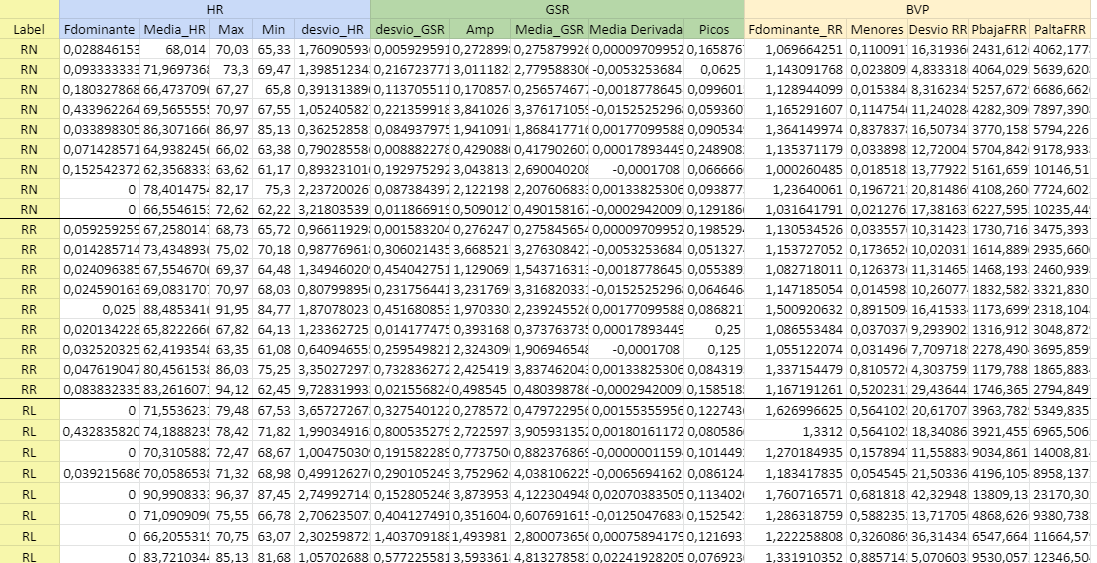![image.png]()

#Clasificacion con Machine Learning y optimización de características

##Funcion para métricas de algoritmos

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
import statsmodels.api as sm

In [28]:
def metricas(matriz):
  tp=[]
  tp.append(matriz[0][0])
  tp.append(matriz[1][1])
  tp.append(matriz[2][2])
  tp.append(matriz[3][3])
  total_tp=sum(tp)

  fp=[]
  fp.append( matriz[1][0]+ matriz[2][0]+ matriz[3][0])
  fp.append( matriz[0][1]+ matriz[2][1]+ matriz[3][1])
  fp.append( matriz[0][2]+ matriz[1][2]+ matriz[3][2])
  fp.append( matriz[0][3]+ matriz[1][3]+ matriz[2][3])
  total_fp=sum(fp)

  fn=[]
  fn.append(matriz[0][1] + matriz[0][2] + matriz[0][3])
  fn.append(matriz[1][0] + matriz[1][2] + matriz[1][3])
  fn.append(matriz[2][0] + matriz[2][1] + matriz[2][3])
  fn.append( matriz[3][0] + matriz[3][1] + matriz[3][2])
  total_fn=sum(fn)

  tn=[]
  tn.append(np.sum(matriz)-tp[0]-fp[0]-fn[0])
  tn.append(np.sum(matriz)-tp[1]-fp[1]-fn[1])
  tn.append(np.sum(matriz)-tp[2]-fp[2]-fn[2])
  tn.append(np.sum(matriz)-tp[3]-fp[3]-fn[3])
  total_tn=sum(tn)

  Accuracy_int= (tp[0] +tn[0])/(tp[0]+tn[0]+fp[0]+fn[0])
  Accuracy_nac= (tp[1] +tn[1])/(tp[1]+tn[1]+fp[1]+fn[1])
  Accuracy_des= (tp[2] +tn[2])/(tp[2]+tn[2]+fp[2]+fn[2])
  Accuracy_dep= (tp[3] +tn[3])/(tp[3]+tn[3]+fp[3]+fn[3])


  Precision_int= (tp[0])/(tp[0]+fp[0])
  Precision_nac= (tp[1])/(tp[1]+fp[1])
  Precision_des= (tp[2])/(tp[2]+fp[2])
  Precision_dep= (tp[3])/(tp[3]+fp[3])



  Recall_int= tp[0]/(tp[0]+fn[0])
  Recall_nac= tp[1]/(tp[1]+fn[1])
  Recall_des= tp[2]/(tp[2]+fn[2])
  Recall_dep= tp[3]/(tp[3]+fn[3])



  F1_Score_int= (2*Precision_int*Recall_int)/ (Precision_int+Recall_int)
  F1_Score_nac= (2*Precision_nac*Recall_nac)/ (Precision_int+Recall_nac)
  F1_Score_des= (2*Precision_des*Recall_des)/ (Precision_int+Recall_des)
  F1_Score_dep= (2*Precision_dep*Recall_dep)/ (Precision_int+Recall_dep)

  TVP_int= (tp[0])/ (tp[0]+fn[0]) # tasa verdaderos positivos
  TVP_nac= (tp[1])/ (tp[1]+fn[1]) #
  TVP_des= (tp[2])/ (tp[2]+fn[2]) 
  TVP_dep= (tp[3])/ (tp[3]+fn[3])


  TFP_int=fp[0]/ (fp[0]+tn[0])  #tasa falsos positivos
  TFP_nac=fp[1]/ (fp[1]+tn[1])  #tasa falsos positivos
  TFP_des=fp[2]/ (fp[2]+tn[2])  #tasa falsos positivos
  TFP_dep=fp[3]/ (fp[3]+tn[3])  #tasa falsos positivos

  total_Accuracy= (total_tp +total_tn)/(total_tp+total_tn+total_fp+total_fn)
  total_Precision=(total_tp)/(total_tp+total_fp)
  total_Recall=(total_tp)/(total_tp+total_fn)
  total_score1=(2*total_Precision*total_Recall)/ (total_Precision+total_Recall)
  total_TVP=(total_tp)/ (total_tp+total_fn)
  total_TFP=total_fp/ (total_fp+total_tn)  

  vector={'Accuracy':[total_Accuracy],'Precision':[total_Precision],'Recall':[total_Recall],'Score1':[total_score1],'Tasa FP':[total_TFP],'Tasa TP':[total_TVP]}
  df=pd.DataFrame(vector)
  return df



##Algoritmo K vecinos mas cercanos con distancia pesada

Importamos el archivo de excel con la matriz de caracteristicas. Luego definimos al vector X con todos los atributos e Y que es la variable objetivo como todos los labels.

In [33]:
data = pd.read_excel("/content/drive/MyDrive/TP Final PSB/P3.xlsx")
train,test = train_test_split(data, test_size=0.3,random_state=0)

x_train = train[['Fdominante',	'Media_HR',	'Max',	'Min',	'desvio_HR',	'desvio_GSR',	'Amp',	'Media_GSR'	,'Media Derivada','Picos'	,'Fdominante_RR',	'Menores'	,'Desvio RR',	'PbajaFRR',	'PaltaFRR']]
y_train = train[['Label']]
x_test = test[['Fdominante',	'Media_HR',	'Max',	'Min',	'desvio_HR',	'desvio_GSR',	'Amp',	'Media_GSR'	,'Media Derivada','Picos'	,'Fdominante_RR',	'Menores'	,'Desvio RR',	'PbajaFRR',	'PaltaFRR']]
y_test = test[['Label']]

La función "Permutation feature importance" es una técnica de inspección del modelo que es muy útil para estimadores no lineales.  Esta función  se define como la disminución en la puntuación de un modelo cuando un único valor de característica se mezcla aleatoriamente.

 Este procedimiento rompe la relación entre la característica y el objetivo, por lo que la caída en la puntuación del modelo es indicativa de cuánto el modelo depende de la función. Esta técnica se beneficia de ser independiente del modelo y se puede calcular muchas veces con diferentes características

Sintetizando entonces, la función permutation_importance calcula la importancia de las características de los estimadores para un conjunto de datos determinado. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.40800
Feature: 14, Score: 0.64800


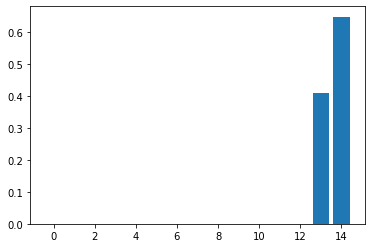

In [34]:
vecinos = KNeighborsClassifier(n_neighbors=3, weights='distance')
vecinos.fit(x_train, y_train)
results = permutation_importance(vecinos, x_train, y_train, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':


   Accuracy  Precision  Recall  Score1  Tasa FP  Tasa TP
0       1.0        1.0     1.0     1.0      0.0      1.0


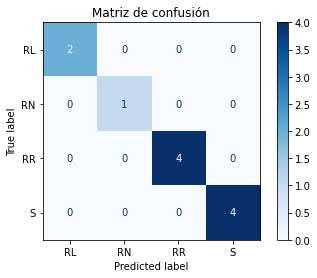

In [35]:
train,test = train_test_split(data, test_size=0.3,random_state=0)

x_train = train[['PbajaFRR',	'PaltaFRR']]
y_train = train[['Label']]
x_test = test[['PbajaFRR',	'PaltaFRR']]
y_test = test[['Label']]

vecinos = KNeighborsClassifier(n_neighbors=3, weights='distance')
vecinos.fit(x_train, y_train)
predicciones=vecinos.predict(x_test)

class_names=['RL','RN','RR','S']
matriz=confusion_matrix(y_test, predicciones)

disp = plot_confusion_matrix(vecinos,x_test, y_test, display_labels = class_names, cmap = plt.cm.Blues)
disp.ax_.set_title('Matriz de confusión')

valores=metricas(matriz)
print(valores)


Verificamos que si agregamos características el resultado no cambia ( ya que no resultan significativas)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


   Accuracy  Precision  Recall  Score1  Tasa FP  Tasa TP
0       1.0        1.0     1.0     1.0      0.0      1.0


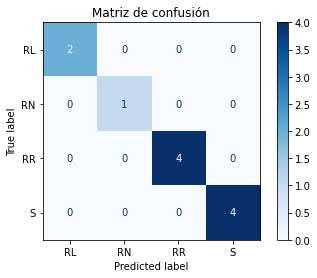

In [36]:
x_train = train[['Fdominante',	'Media_HR',	'Max','Desvio RR',	'PbajaFRR',	'PaltaFRR']]
y_train = train[['Label']]
x_test = test[['Fdominante',	'Media_HR',	'Max','Desvio RR',	'PbajaFRR',	'PaltaFRR']]
y_test = test[['Label']]

vecinos = KNeighborsClassifier(n_neighbors=3, weights='distance')
vecinos.fit(x_train, y_train)
predicciones=vecinos.predict(x_test)

class_names=['RL','RN','RR','S']
matriz=confusion_matrix(y_test, predicciones)


disp = plot_confusion_matrix(vecinos,x_test, y_test, display_labels = class_names, cmap = plt.cm.Blues)
disp.ax_.set_title('Matriz de confusión')

valores=metricas(matriz)
print(valores)


##Algoritmo SVM

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.20800
Feature: 14, Score: 0.48800


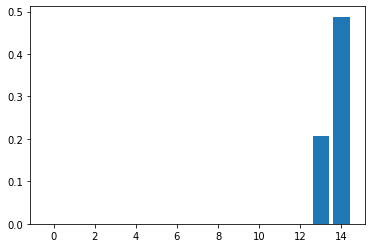

In [37]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

data = pd.read_excel("/content/drive/MyDrive/TP Final PSB/P3.xlsx")
train,test = train_test_split(data, test_size=0.3,random_state=0)

x_train = train[['Fdominante',	'Media_HR',	'Max',	'Min',	'desvio_HR',	'desvio_GSR',	'Amp',	'Media_GSR'	,'Media Derivada','Picos'	,'Fdominante_RR',	'Menores'	,'Desvio RR',	'PbajaFRR',	'PaltaFRR']]
y_train = train[['Label']]
x_test = test[['Fdominante',	'Media_HR',	'Max',	'Min',	'desvio_HR',	'desvio_GSR',	'Amp',	'Media_GSR'	,'Media Derivada','Picos'	,'Fdominante_RR',	'Menores'	,'Desvio RR',	'PbajaFRR',	'PaltaFRR']]
y_test = test[['Label']]

clf =svm.SVC(kernel='rbf')
clf.fit(x_train,y_train)
results = permutation_importance(clf, x_train, y_train, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   Accuracy  Precision    Recall    Score1   Tasa FP   Tasa TP
0  0.954545   0.909091  0.909091  0.909091  0.030303  0.909091


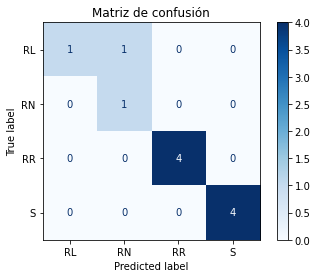

In [38]:
x_train = train[['PbajaFRR',	'PaltaFRR']]
y_train = train[['Label']]
x_test = test[['PbajaFRR',	'PaltaFRR']]
y_test = test[['Label']]


clf =svm.SVC(kernel='rbf')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)


class_names=['RL','RN','RR','S']
matriz=confusion_matrix(y_test, y_pred)



disp = plot_confusion_matrix(clf,x_test, y_test, display_labels = class_names, cmap = plt.cm.Blues)
disp.ax_.set_title('Matriz de confusión')


print(metricas(matriz))

#Conclusiones

De las 15 caracteristicas analizadas en las distintas señales, las más significativas para la clasificacion de las diferentes etapas resultaron ser la potencia en la banda de baja y alta frecuencia de la señal de BVP. Esto tiene sentido ya que, como mencionamos, la banda de baja frecuencia está relacionada a la actividad simpática y la de alta frecuencia a la actividad parasimpática. Un aumento en la potencia de la banda de alta frecuencia puede estar relacionado a la presencia de estrés, mientras que un aumento en la banda de baja frecuencia indicaría la ausencia del mismo.

Concluimos que la caracterización de las señales fisiológicas otorgan la posibilidad de detección de estres y diferentes etapas de manera eficiente y rápida.

Con lo que respecta a los métodos de clasificacion, tanto con K vecinos mas cercanos como con SVM obtenemos resultados muy buenos con una precisión de 100% y 90%  respectivamente. 



---




#Referencias

* Rescio, G., Leone, A., & Siciliano, P. (2020). Unsupervised-based Framework for Aged Worker's Stress Detection

* Jin, Claire W. and Osotsi, Ame and Oravecz, Zita.(2020) Predicting Stress in Teens from Wearable Device Data Using Machine Learning Methods

* Sara Guardiola Vila (2015) .Análisis de señales biomédicas para la detección del nivel de estrés en conductores. 

* Principal, P., médica, E. and salud, E., 2021. El estrés y su salud: MedlinePlus enciclopedia médica. [online] Medlineplus.gov. Available at: <https://medlineplus.gov/spanish/ency/article/003211.htm> .
